In [129]:
import os 
import sys

import sklearn as sk
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 
import xgboost as xgb

from scipy.stats import kurtosis, entropy
from scipy.fft import fft

sys.path.append(r"c:\Users\keng-tse\Desktop\csi_tool") #這行為絕對路徑，如需使用，必須要修改為當前決路徑
import csi_tool

In [131]:
base_path = r"C:\Users\keng-tse\Desktop\csi_tool\csi_dataset\localization_phone\1223_phone\5G\20MHz\csv\all"
base_path2 = r"C:\Users\keng-tse\Desktop\csi_tool\csi_dataset\localization_phone\1222_phone\5G\20MHz\csv\all"
base_path3 = r"C:\Users\keng-tse\Desktop\csi_tool\csi_dataset\localization_phone\1221_phone\5G\20MHz\csv\all"

In [133]:
# 每個點的實際位置 (x, y)，基於 0.6m 的間距
spacing = 0.6  # 每隔 0.6m
coordinates = {
    # 下邊界 (1-10 和 40-31)
    1: (0, 0), 40: (0.6, 0), 39: (1.2, 0), 38: (1.8, 0), 37: (2.4, 0),
    36: (3.0, 0), 35: (3.6, 0), 34: (4.2, 0), 33: (4.8, 0), 32: (5.4, 0), 31: (6.0, 0),

    # 左邊界 (1-11)
    2: (0, 0.6), 3: (0, 1.2), 4: (0, 1.8), 5: (0, 2.4),
    6: (0, 3.0), 7: (0, 3.6), 8: (0, 4.2), 9: (0, 4.8), 10: (0, 5.4), 11: (0, 6.0),

    # 上邊界 (11-21)
    12: (0.6, 6.0), 13: (1.2, 6.0), 14: (1.8, 6.0), 15: (2.4, 6.0),
    16: (3.0, 6.0), 17: (3.6, 6.0), 18: (4.2, 6.0), 19: (4.8, 6.0),
    20: (5.4, 6.0), 21: (6.0, 6.0),

    # 右邊界 (21-31)
    22: (6.0, 5.4), 23: (6.0, 4.8), 24: (6.0, 4.2), 25: (6.0, 3.6),
    26: (6.0, 3.0), 27: (6.0, 2.4), 28: (6.0, 1.8), 29: (6.0, 1.2), 30: (6.0, 0.6),

    # 中間點 (41-49)
    41: (3.0, 0.6), 42: (3.0, 1.2), 43: (3.0, 1.8),
    44: (3.0, 2.4), 45: (3.0, 3.0), 46: (3.0, 3.6),
    47: (3.0, 4.2), 48: (3.0, 4.8), 49: (3.0, 5.4)
}

In [135]:
reference_points = {}
reference_points2 = {}
reference_points3 = {}
# 生成 reference_points 字典
for ref_id, coord in coordinates.items():
    folder_path = os.path.join(base_path, f"reference_point_{ref_id}.xlsx")
    reference_points[folder_path] = (ref_id, coord)

for ref_id, coord in coordinates.items():
    folder_path2 = os.path.join(base_path2, f"reference_point_{ref_id}.xlsx")
    reference_points2[folder_path2] = (ref_id, coord)

for ref_id, coord in coordinates.items():
    folder_path3 = os.path.join(base_path3, f"reference_point_{ref_id}.xlsx")
    reference_points3[folder_path3] = (ref_id, coord)

In [137]:
def load_data(reference_points):
    data = []          # 用于存储所有数据
    rp_labels = []     # 用于存储参考点编号标签
    coord_labels = []  # 用于存储 (x, y) 坐标标签

    for path, (ref_id, coord) in reference_points.items():
        df = pd.read_excel(path)
        data.append(df.values)
        rp_labels.extend([ref_id] * len(df))
        coord_labels.extend([coord] * len(df))
    data = pd.DataFrame(np.vstack(data))
    rp_labels = pd.Series(rp_labels, name="Reference Point ID")
    coord_labels = pd.DataFrame(coord_labels, columns=["X", "Y"])
    return data, rp_labels, coord_labels

In [139]:
data, rp_labels, coord_labels = load_data(reference_points)
data2, rp_labels2, coord_labels2 = load_data(reference_points2)
data3, rp_labels3, coord_labels3 = load_data(reference_points3)

In [140]:
#data

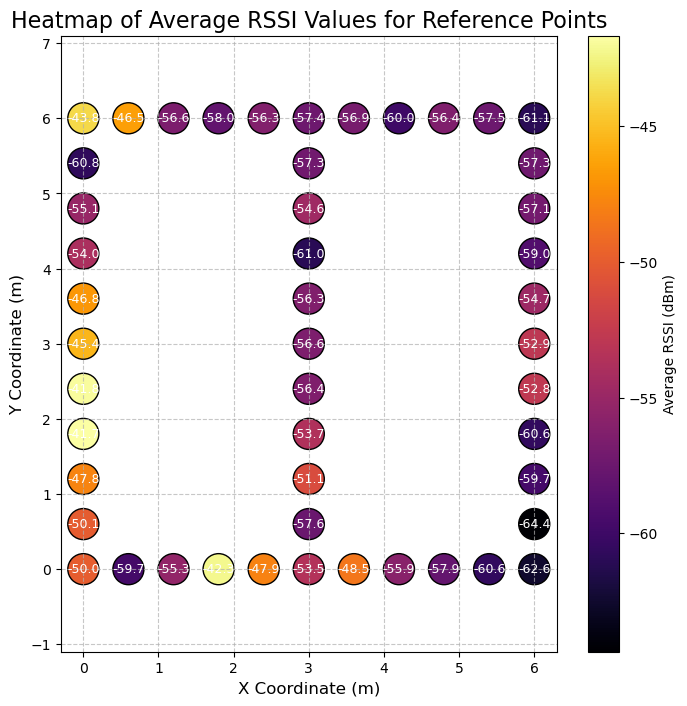

In [141]:
# 提取 RSSI 值 (倒数第二列)
rssi_values = data.iloc[:, -2]
# 計算每個參考點的平均 RSSI
avg_rssi = rssi_values.groupby(rp_labels).mean()

# 提取 x, y 座標
coords = coord_labels.groupby(rp_labels).first()
x_coords = coords["X"].values
y_coords = coords["Y"].values

# 繪製熱力圖
plt.figure(figsize=(8, 8))
scatter = plt.scatter(x_coords, y_coords, c=avg_rssi, cmap="inferno", s=500, edgecolor="black")
plt.colorbar(scatter, label="Average RSSI (dBm)")

# 添加標籤
for label, x, y, rssi in zip(avg_rssi.index, x_coords, y_coords, avg_rssi.values):
    plt.text(x, y, f"{rssi: .1f}", fontsize=9, ha='center', va='center', color="white")

# 圖形設定
plt.title("Heatmap of Average RSSI Values for Reference Points", fontsize=16)
plt.xlabel("X Coordinate (m)", fontsize=12)
plt.ylabel("Y Coordinate (m)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.axis("equal")  # 保持比例
plt.show()

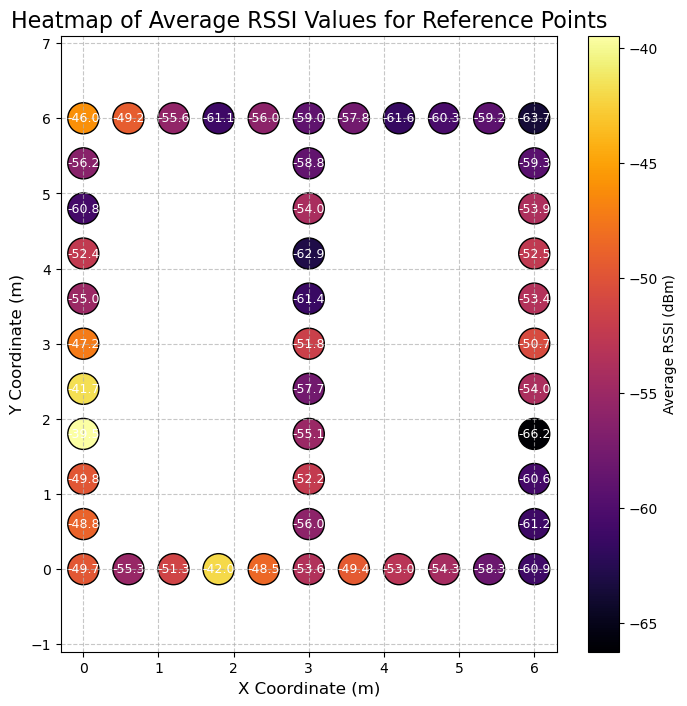

In [142]:
# 提取 RSSI 值 (倒数第二列)
rssi_values2 = data2.iloc[:, -2]
# 計算每個參考點的平均 RSSI
avg_rssi2 = rssi_values2.groupby(rp_labels2).mean()

# 提取 x, y 座標
coords = coord_labels.groupby(rp_labels2).first()
x_coords = coords["X"].values
y_coords = coords["Y"].values

# 繪製熱力圖
plt.figure(figsize=(8, 8))
scatter = plt.scatter(x_coords, y_coords, c=avg_rssi2, cmap="inferno", s=500, edgecolor="black")
plt.colorbar(scatter, label="Average RSSI (dBm)")

# 添加標籤
for label, x, y, rssi in zip(avg_rssi2.index, x_coords, y_coords, avg_rssi2.values):
    plt.text(x, y, f"{rssi: .1f}", fontsize=9, ha='center', va='center', color="white")

# 圖形設定
plt.title("Heatmap of Average RSSI Values for Reference Points", fontsize=16)
plt.xlabel("X Coordinate (m)", fontsize=12)
plt.ylabel("Y Coordinate (m)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.axis("equal")  # 保持比例
plt.show()

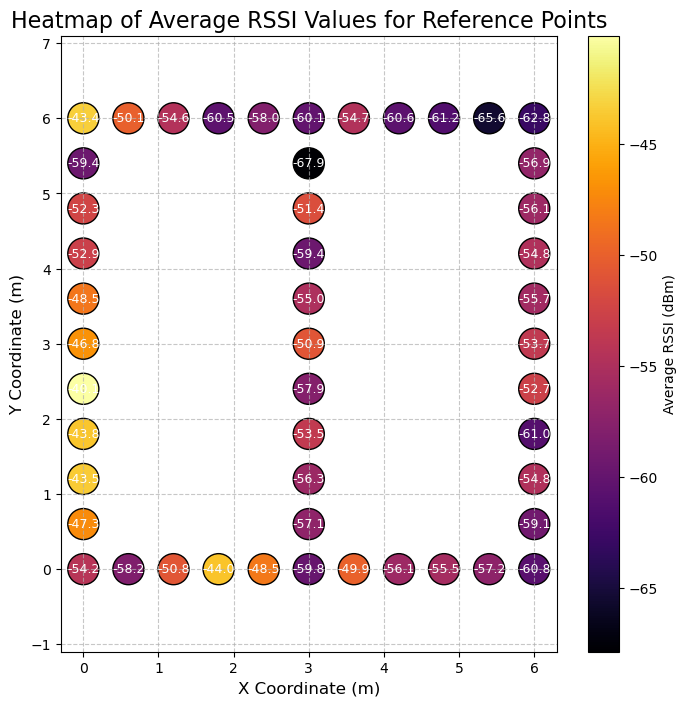

In [143]:
# 提取 RSSI 值 (倒数第二列)
rssi_values3 = data3.iloc[:, -2]
# 計算每個參考點的平均 RSSI
avg_rssi3 = rssi_values3.groupby(rp_labels3).mean()

# 提取 x, y 座標
coords = coord_labels.groupby(rp_labels3).first()
x_coords = coords["X"].values
y_coords = coords["Y"].values

# 繪製熱力圖
plt.figure(figsize=(8, 8))
scatter = plt.scatter(x_coords, y_coords, c=avg_rssi3, cmap="inferno", s=500, edgecolor="black")
plt.colorbar(scatter, label="Average RSSI (dBm)")

# 添加標籤
for label, x, y, rssi in zip(avg_rssi3.index, x_coords, y_coords, avg_rssi3.values):
    plt.text(x, y, f"{rssi: .1f}", fontsize=9, ha='center', va='center', color="white")

# 圖形設定
plt.title("Heatmap of Average RSSI Values for Reference Points", fontsize=16)
plt.xlabel("X Coordinate (m)", fontsize=12)
plt.ylabel("Y Coordinate (m)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.axis("equal")  # 保持比例
plt.show()

In [144]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

#scaler = StandardScaler()
#rssi1 = scaler.fit_transform(np.array(rssi_values2).reshape(-1,1))
rssi1 = np.array(rssi_values).reshape(-1,1)


# 切分數據集
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:-2], rp_labels, test_size=0.2, random_state=1)
#X_train, X_test, y_train, y_test = preprocess_data(rssi1, rp_labels)
# 初始化 KNN 模型
knn = KNeighborsClassifier(n_neighbors=4)

# 訓練模型
knn.fit(X_train, y_train)

# 測試模型
y_pred = knn.predict(X_test)

# 評估模型
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[110   0   0 ...   0   0   0]
 [  0 103   0 ...   0   0   0]
 [  0   0 108 ...   0   0   0]
 ...
 [  0   0   0 ... 119   0   0]
 [  0   0   0 ...   0  82   0]
 [  0   0   0 ...   0   0 101]]
              precision    recall  f1-score   support

           1       0.99      0.97      0.98       113
           2       1.00      0.98      0.99       105
           3       1.00      1.00      1.00       108
           4       0.99      0.98      0.99       108
           5       0.90      1.00      0.95        92
           6       0.97      1.00      0.98        92
           7       0.97      1.00      0.99       108
           8       0.98      0.97      0.98       109
           9       0.99      1.00      1.00       105
          10       0.99      0.98      0.98        95
          11       0.99      1.00      0.99        80
          12       0.95      0.99      0.97       107
          13       1.00      1.00      1.00        90
          14       0.99      0.99      0.99       1

In [88]:
# 合併三天的資料
combined_data = pd.concat([data, data2, data3], ignore_index=True)
combined_rp_labels = pd.concat([rp_labels, rp_labels2, rp_labels3], ignore_index=True)
combined_coord_labels = pd.concat([coord_labels, coord_labels2, coord_labels3], ignore_index=True)

# 查看合併後的資料
print(combined_data.head())
print(combined_rp_labels.head())
print(combined_coord_labels.head())

           0           1           2           3           4           5   \
0  698.204841  732.963846  684.079674  694.257877  651.079872  672.521375   
1  745.268408  768.188128  706.606680  713.252410  681.482208  713.950278   
2  830.278267  829.860832  804.005597  796.492310  786.787138  800.870776   
3  906.099884  903.507056  910.843565  896.688352  892.235955  875.416472   
4  702.353188  739.530256  713.168283  713.050489  679.002946  671.471518   

           6           7           8           9   ...        88        89  \
0  687.674342  780.946221  803.560203  863.103702  ... -2.677159 -2.877730   
1  736.619983  852.877482  846.442556  880.032954  ...  0.176051 -0.063704   
2  791.982323  778.923616  763.872372  766.167084  ... -1.031820 -1.194379   
3  878.300632  854.687077  857.886939  843.664033  ... -0.445534 -0.593750   
4  691.920516  788.726188  837.376857  864.653110  ...  2.956138  2.800554   

         90        91        92        93        94        95    96 

In [89]:
combined_data.shape

(73353, 98)

In [123]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 計算每個特徵的標準差
feature_variance = combined_data.iloc[:,:48].std(axis=0)

# 按標準差排序，選擇標準差最小的前 10 個特徵
sorted_features = feature_variance.sort_values()  # 升冪排序
stable_features = sorted_features.head(10).index  # 選擇前 10 個最穩定的特徵

# 這樣就可以選擇穩定特徵
print("最穩定的特徵:", stable_features)



最穩定的特徵: Index([28, 29, 30, 31, 26, 27, 32, 33, 16, 15], dtype='int64')


In [125]:
feature_variance.sort_values()

28    154.813051
29    158.395512
30    160.136712
31    166.366404
26    171.816809
27    172.080067
32    174.782590
33    181.961922
16    182.204307
15    184.890359
19    186.067440
17    186.765856
34    188.776369
12    191.021350
25    192.502022
13    193.269101
18    193.623806
35    193.827805
14    193.852941
36    196.469740
40    197.468362
39    197.879921
11    198.779640
9     199.118559
41    200.054641
38    200.755729
7     200.977900
6     201.145994
37    201.599376
42    202.300470
5     202.870651
8     202.963921
10    203.494598
43    205.520323
20    205.897144
3     206.539115
4     206.653406
21    207.263832
22    210.848408
44    212.216809
2     213.013966
0     213.551652
45    215.907983
1     217.979378
46    224.067977
47    227.426111
23    253.959952
24    358.877527
dtype: float64

In [119]:
# 計算每個特徵的標準差
feature_variance = data.iloc[:,:48].std(axis=0)

# 按標準差排序，選擇標準差最小的前 10 個特徵
sorted_features = feature_variance.sort_values()  # 升冪排序
stable_features = sorted_features.head(10).index  # 選擇前 10 個最穩定的特徵

# 這樣就可以選擇穩定特徵
print("最穩定的特徵:", stable_features)

最穩定的特徵: Index([30, 31, 17, 32, 33, 15, 29, 28, 14, 34], dtype='int64')


In [127]:
feature_variance.sort_values()

28    154.813051
29    158.395512
30    160.136712
31    166.366404
26    171.816809
27    172.080067
32    174.782590
33    181.961922
16    182.204307
15    184.890359
19    186.067440
17    186.765856
34    188.776369
12    191.021350
25    192.502022
13    193.269101
18    193.623806
35    193.827805
14    193.852941
36    196.469740
40    197.468362
39    197.879921
11    198.779640
9     199.118559
41    200.054641
38    200.755729
7     200.977900
6     201.145994
37    201.599376
42    202.300470
5     202.870651
8     202.963921
10    203.494598
43    205.520323
20    205.897144
3     206.539115
4     206.653406
21    207.263832
22    210.848408
44    212.216809
2     213.013966
0     213.551652
45    215.907983
1     217.979378
46    224.067977
47    227.426111
23    253.959952
24    358.877527
dtype: float64